loading annotations into memory...
Done (t=1.43s)
creating index...
index created!


(['Closeup of bins of food that include broccoli and bread.',
  'A meal is presented in brightly colored plastic trays.',
  'there are containers filled with different kinds of foods',
  'Colorful dishes holding meat, vegetables, fruit, and bread.',
  'A bunch of trays that have different food.'],
 torch.Size([3, 256, 256]))

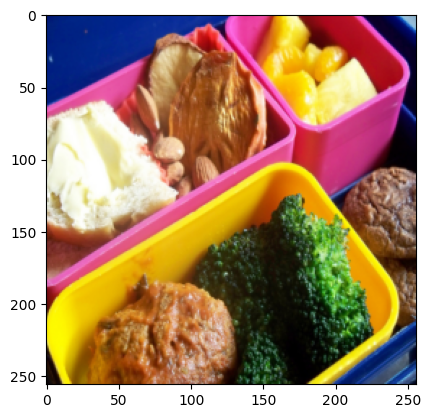

In [2]:
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import CocoCaptions
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

IMAGE_SIZE = 256

transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset = CocoCaptions(
    root="C:/Datasets/coco2017/train2017",
    annFile="C:/Datasets/coco2017/annotations/captions_train2017.json",
    transform=transform,
)

test_img, labels = dataset[0]
test_img = test_img * 0.5 + 0.5
plt.imshow(test_img.permute(1, 2, 0))
labels, test_img.shape

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


'bread with banana milk and nutella on a table'

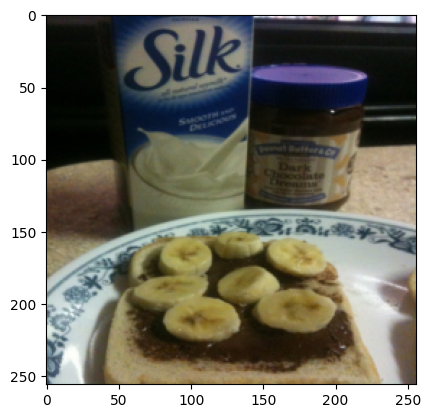

In [41]:
from random import choice

class SigmaDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = CocoCaptions(
            root="C:/Datasets/coco2017/train2017",
            annFile="C:/Datasets/coco2017/annotations/captions_train2017.json",
            transform=transform,
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, text_labels = self.dataset[idx]
        random_text = choice(text_labels)
        return img, random_text
    
sigma_dataset = SigmaDataset(dataset)
test_img, text = sigma_dataset[27]
test_img = test_img * 0.5 + 0.5
plt.imshow(test_img.permute(1, 2, 0))
text

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017280597..1.0151311].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6234972..2.3824368].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.865715..3.3620958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7051103..4.1424437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.618527..4.5993605].


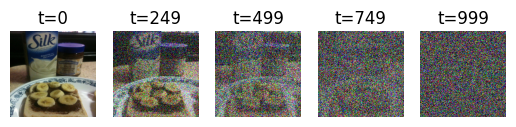

In [42]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
)

noise = torch.randn(5, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
test_batch = test_img.unsqueeze(0).repeat(5, 1, 1, 1).to(device)
timesteps = torch.LongTensor([0, 249, 499, 749, 999])
noised = scheduler.add_noise(test_batch, noise, timesteps)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(noised[i].cpu().detach().permute(1, 2, 0))
    plt.title(f"t={timesteps[i]}")
    plt.axis("off")

### 1. Autoencoder (VAE)

In [17]:
from diffusers import AutoencoderTiny

vae = AutoencoderTiny.from_pretrained("madebyollin/taesdxl", torch_dtype=torch.float32).to(device)
vae = vae.eval().requires_grad_(False)
vae

AutoencoderTiny(
  (encoder): EncoderTiny(
    (layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip): Identity()
        (fuse): ReLU()
      )
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (3): AutoencoderTinyBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

test reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12913847..1.0688293].


torch.Size([3, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

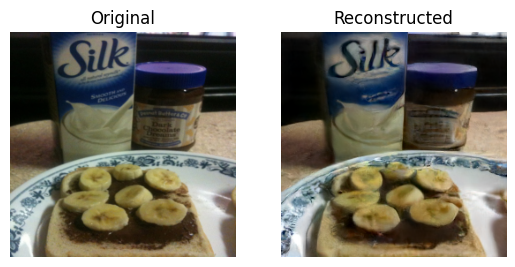

In [50]:
print(test_img.shape)
original = test_img.unsqueeze(0).to(device)

reconstructed = vae(original).sample

plt.subplot(1, 2, 1)
plt.imshow(original.cpu().detach().squeeze().permute(1, 2, 0))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().detach().squeeze().permute(1, 2, 0))
plt.title("Reconstructed")
plt.axis("off")

test encoding

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1515076..2.5788312].


torch.Size([1, 4, 32, 32])


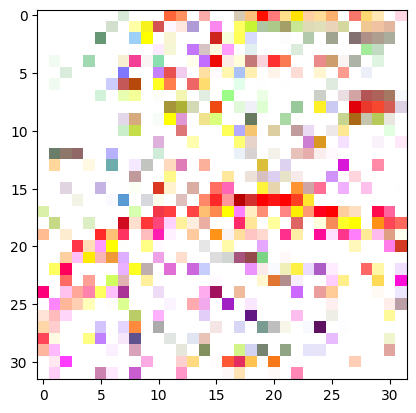

In [51]:
encoded = vae.encode(original).latents
print(encoded.shape)

# visualize latents in rgba
plt.imshow(encoded.cpu().detach().squeeze().permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14058095..1.0775912].


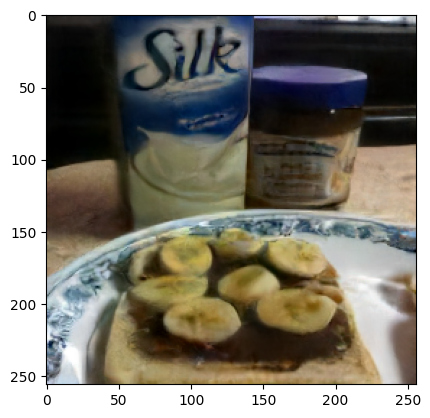

In [52]:
decoded = vae.decode(encoded).sample
plt.imshow(decoded.cpu().detach().squeeze().permute(1, 2, 0))

In [44]:
from transformers import CLIPModel, CLIPTokenizerFast

tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").text_model.requires_grad_(False).to(device)

def encode_text(text):
    with torch.no_grad():
        return model(tokenizer(text, return_tensors="pt").input_ids.to(device)).last_hidden_state
    
def encode_text_batch(texts):
    with torch.no_grad():
        return model(tokenizer(texts, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)).last_hidden_state

In [55]:
from tqdm import tqdm
from torch import optim
from diffusers import UNet2DConditionModel

latent_unet_model = UNet2DConditionModel(
    sample_size=32,
    in_channels=4,
    out_channels=4,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    block_out_channels=(64, 128, 256),
    cross_attention_dim=512
).to(device)
vae = AutoencoderTiny.from_pretrained("madebyollin/taesdxl", torch_dtype=torch.float32).to(device)
vae = vae.eval().requires_grad_(False)
SigmaLoader = DataLoader(sigma_dataset, batch_size=64, shuffle=True)
optimizer = optim.Adam(latent_unet_model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()
NUM_EPOCHS = 20

In [60]:
from torchvision.utils import save_image, make_grid

@torch.no_grad()
def model_sample(model, vae, text, scheduler, inference_steps=1000, num_samples=1):
    model.eval()
    text_embedding = encode_text(text).to(device).repeat(num_samples, 1, 1)
    sample = torch.randn(num_samples, 4, 32, 32).to(device)
    scheduler.set_timesteps(inference_steps)

    for t in tqdm(range(999, -1, -(scheduler.num_train_timesteps // inference_steps))):
        sample = scheduler.scale_model_input(sample, t).to(device)
        out = model(sample, torch.LongTensor([t] * num_samples).to(device), text_embedding).sample
        out = scheduler.step(out, t, sample)
        sample = out.prev_sample
        pred_t_0 = out.pred_original_sample

    sample = vae.decode(sample).sample
    return sample

c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 1000/1000 [00:18<00:00, 54.31it/s]


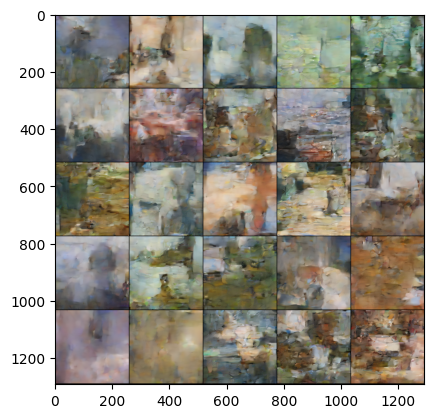

In [64]:
test_sample = model_sample(latent_unet_model, vae, "bread with banana milk and nutella on a table", scheduler, num_samples=25)

test_sample = make_grid(test_sample, nrow=5, normalize=True)
plt.imshow(test_sample.cpu().permute(1, 2, 0))

In [62]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}", end=" ")
    pbar = tqdm(SigmaLoader, total=len(SigmaLoader), leave=True)
    latent_unet_model.train()

    for imgs, texts in pbar:
        imgs = imgs.to(device)
        imgs = vae.encode(imgs).latents

        texts = encode_text_batch(texts).to(device)
        noise = torch.randn(imgs.shape).to(device)
        timesteps = torch.randint(0, 1000, (imgs.shape[0], )).to(device)
        noised = scheduler.add_noise(imgs, noise, timesteps)
        optimizer.zero_grad()
        out = latent_unet_model(noised, timesteps, texts)
        loss = loss_fn(out.sample, noise)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    latent_unet_model.eval()
    with torch.no_grad():
        sample = model_sample(latent_unet_model, vae, "bread with banana milk and nutella on a table", scheduler, num_samples=25)
        sample = make_grid(sample, nrow=5, normalize=True)
        save_image(sample, f"train_samples/sample_{epoch}.png")
        torch.save(latent_unet_model.state_dict(), f"latent_unetckpt/latent_unet{epoch}.pt")


Epoch 1/20 

  2%|▏         | 28/1849 [00:16<18:06,  1.68it/s, loss=0.2024]


KeyboardInterrupt: 